# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'dataset/df_msg_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "Ecom Multichannel messages"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:
# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False

if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample to test setup
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # use 10% sample file when heavy processing
    # data=pd.read_csv(sample_filepath)
    # test= pd.read_csv(test_sample_filepath)
    # test= pd.read_csv(train_sample_filepath)
 
target='is_clicked'
target_metric='f2'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195562 entries, 0 to 195561
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   platform                      195562 non-null  float64
 1   email_provider                195562 non-null  float64
 2   campaign_type                 195562 non-null  float64
 3   channel_cmp                   195562 non-null  float64
 4   topic                         195562 non-null  float64
 5   total_count                   195562 non-null  float64
 6   subject_length                195562 non-null  float64
 7   day_of_year                   195562 non-null  float64
 8   month                         195562 non-null  float64
 9   hour_sin                      195562 non-null  float64
 10  hour_cos                      195562 non-null  float64
 11  min_sin                       195562 non-null  float64
 12  min_cos                       195562 non-null  fl

# Distribution Check

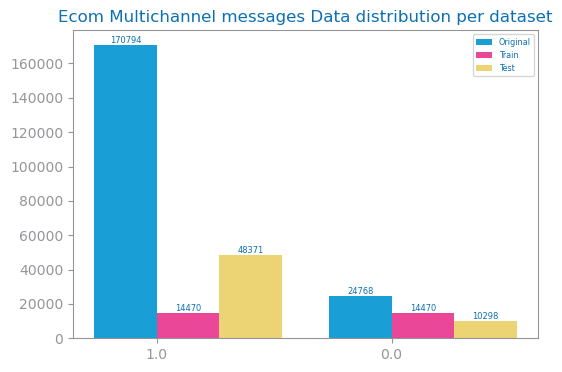

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Original": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title=f"{file_tag} Data distribution per dataset")
show()

# Model Evaluation

In [6]:
trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
print(f'Train#={len(trnX)} Test#={len(tstX)}')
print(f'Labels={labels}')

Train#=28940 Test#=58669
Labels=[0.0, 1.0]


## d max definition

In [7]:
d_max_eval=10 #brincar com isto lelelele, maybe reduzir. 25 inicialmente, dt2 melhor. 10-dt2 melhor.

## recall evaluation

 DT best with entropy and d=2


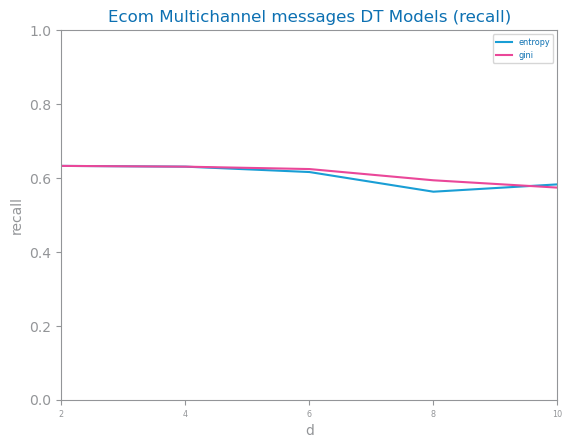

In [8]:
best_model_recall, recall_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='recall', file_tag=file_tag)
savefig(f'images/{file_tag}_dt_recall_study.png')
show()

<Figure size 640x480 with 0 Axes>

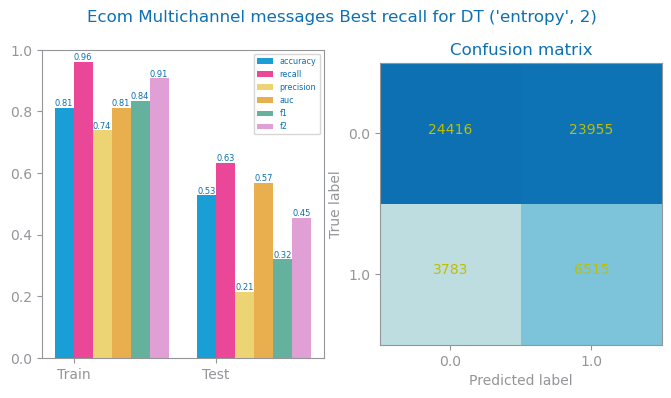

In [9]:
prd_trn: array = best_model_recall.predict(trnX)
prd_tst: array = best_model_recall.predict(tstX)
figure()
plot_evaluation_results(recall_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{recall_params["name"]}_best_{recall_params["metric"]}_eval.png')
show()

## evaluate precision

 DT best with entropy and d=8


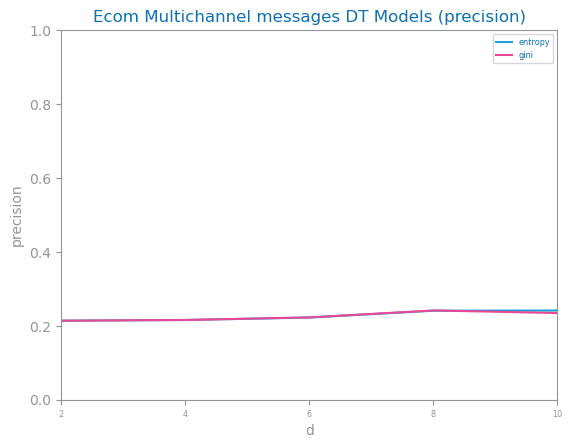

In [10]:
best_model_prec, prec_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='precision', file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{prec_params["metric"]}_study.png')
show()

<Figure size 640x480 with 0 Axes>

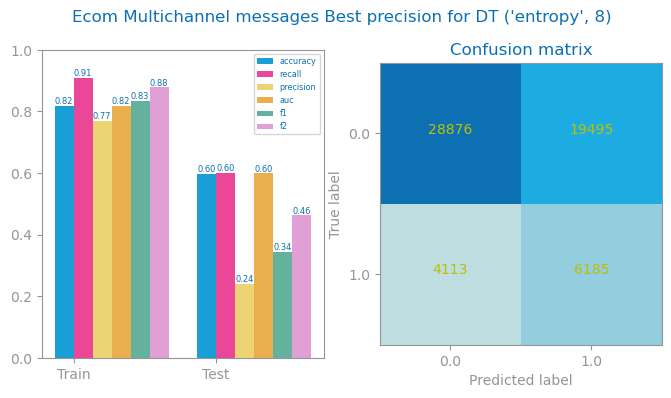

In [11]:
prd_trn: array = best_model_prec.predict(trnX)
prd_tst: array = best_model_prec.predict(tstX)
figure()
plot_evaluation_results(prec_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{prec_params["name"]}_best_{prec_params["metric"]}_eval.png')
show()

## evaluate f2

 DT best with gini and d=8


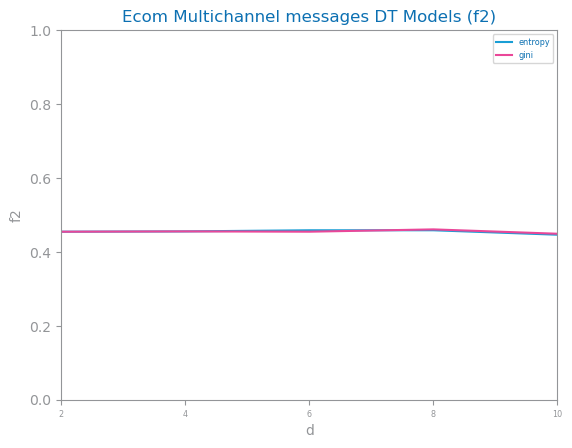

In [12]:
best_model_f2, f2_params = trees_study(trnX, trnY, tstX, tstY, d_max=d_max_eval, metric='f2', file_tag=file_tag)
savefig(f'images/{file_tag}_dt_{f2_params["metric"]}_study.png')
show()

<Figure size 640x480 with 0 Axes>

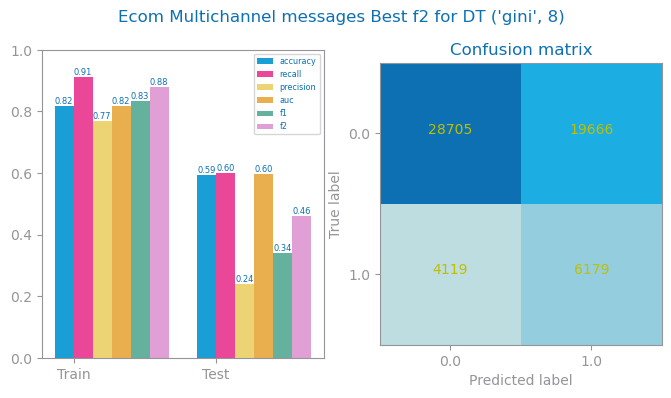

In [13]:
prd_trn: array = best_model_f2.predict(trnX)
prd_tst: array = best_model_f2.predict(tstX)
figure()
plot_evaluation_results(f2_params, trnY, prd_trn, tstY, prd_tst, labels, file_tag=file_tag)
savefig(f'images/{file_tag}_knn_{f2_params["name"]}_best_{f2_params["metric"]}_eval.png')
show()

# F2 Variables importance
IF YOU HAVE AN ERROR YOU MAY NEED TO INSTALL GRAPHVIZ
1. open conda terminal
2. conda install graphviz

## f2 tree evaluation

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.337428 to fit


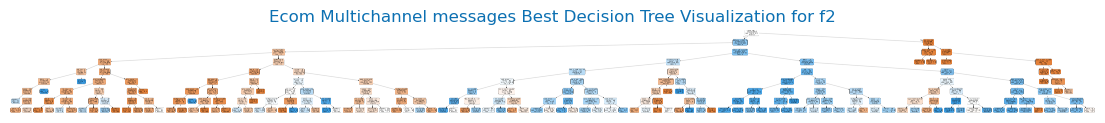

In [15]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis, title
from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{f2_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_f2,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
title(f'{file_tag} Best Decision Tree Visualization for {f2_params['metric']}')
axis("off")
show()

filtrar os dados para is clicked, e agrupado para channel e day of month, no pre proc:
analise:
- 

## f2 simpler tree

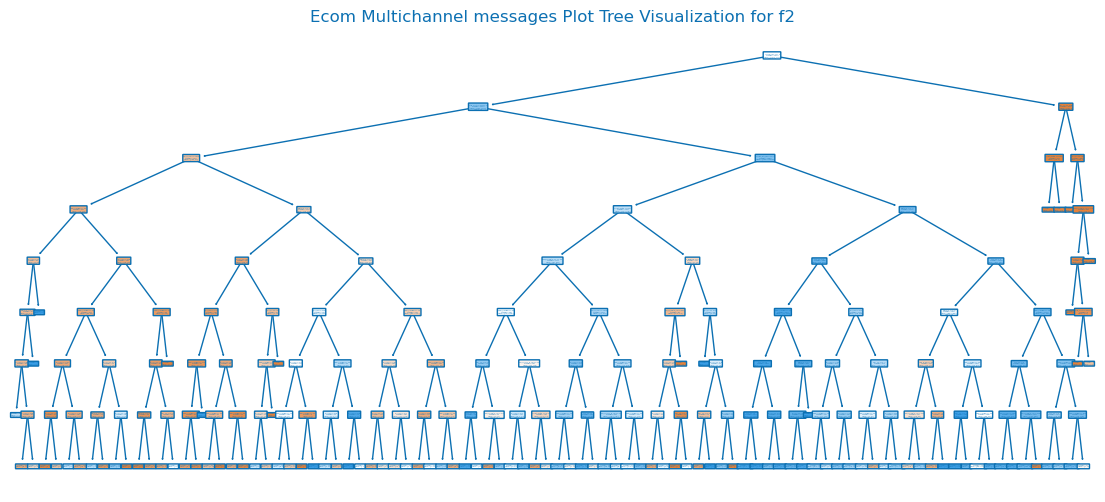

In [16]:
from sklearn.tree import plot_tree
from matplotlib.pyplot import title

figure(figsize=(14, 6))
plot_tree(
    best_model_f2,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")
title(f'{file_tag} Plot Tree Visualization for {f2_params['metric']}')

show()

## f2 Feature Importances

1. channel_cmp (0.8224009307420018)
2. total_count (0.06894129821475624)
3. topic (0.046734548910461825)
4. email_provider (0.0223984152362211)
5. platform (0.010438069168538129)
6. subject_with_emoji (0.00977034915833091)
7. min_cos (0.0047373687004567825)
8. min_sin (0.0034675989528548832)
9. day_of_year (0.002302312002437219)
10. day_of_month_sin (0.002271506316891707)
11. subject_length (0.00177585150456661)
12. hour_sin (0.001469663756986769)
13. week_of_month_cos (0.0011321633166780306)
14. day_of_week_nr_cos (0.0009151975834262783)
15. is_weekend (0.0007047613844433411)
16. time_of_day (0.0005213450419714583)
17. hour_cos (9.837880623400298e-06)
18. week_of_month_sin (8.78212835356287e-06)
19. day_of_week_nr_sin (0.0)
20. subject_with_personalization (0.0)
21. day_of_month_cos (0.0)
22. subject_with_deadline (0.0)
23. subject_with_bonuses (0.0)
24. subject_with_discount (0.0)
25. campaign_type (0.0)
26. subject_with_saleout (0.0)
27. month (0.0)


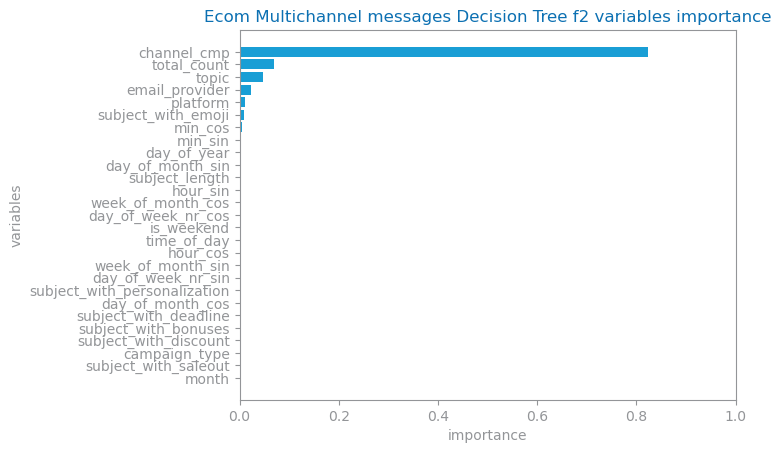

In [17]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_f2.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} Decision Tree {f2_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_vars_ranking.png")
show()

## f2 Overfitting

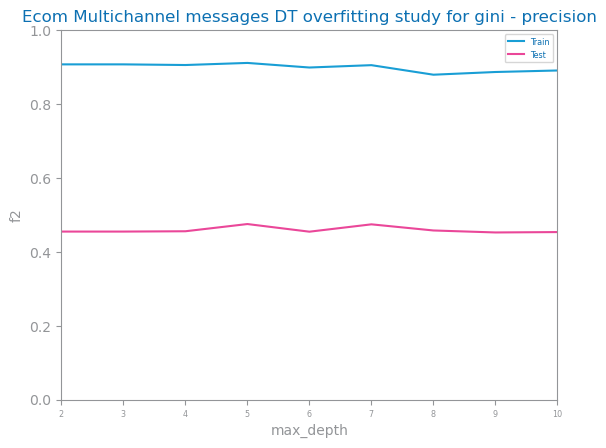

In [18]:
crit: Literal["entropy", "gini"] = f2_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = f2_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(f2_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{f2_params['metric']}_overfitting.png")

# Precision Variables Importance

## precision tree evaluation

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.390721 to fit


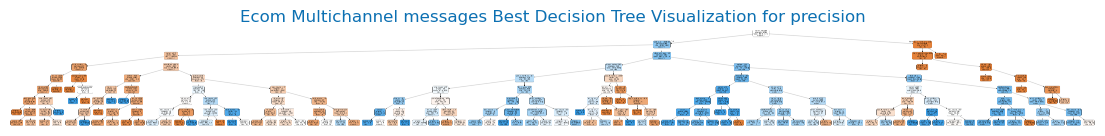

In [19]:
from sklearn.tree import export_graphviz
from matplotlib.pyplot import imread, imshow, axis, title

from subprocess import call

tree_filename: str = f"images/{file_tag}_dt_{prec_params['metric']}_best_tree"
max_depth2show = 8
st_labels: list[str] = [str(value) for value in labels]

dot_data: str = export_graphviz(
    best_model_prec,
    out_file=tree_filename + ".dot",
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    special_characters=True,
    precision=2,
)
# Convert to png
call(
    ["dot", "-Tpng", tree_filename + ".dot", "-o", tree_filename + ".png", "-Gdpi=600"]
)

figure(figsize=(14, 6))
imshow(imread(tree_filename + ".png"))
title(f'{file_tag} Best Decision Tree Visualization for {prec_params['metric']}')
axis("off")
show()

## precision simple tree

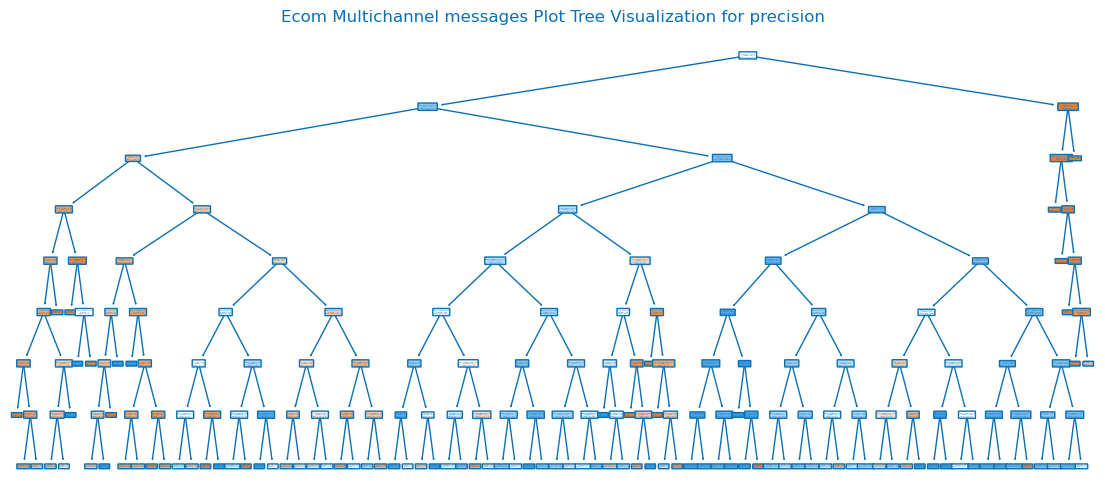

In [20]:
from sklearn.tree import plot_tree

figure(figsize=(14, 6))
plot_tree(
    best_model_prec,
    max_depth=max_depth2show,
    feature_names=vars,
    class_names=st_labels,
    filled=True,
    rounded=True,
    impurity=False,
    precision=2,
)
savefig(tree_filename + "_simple.png")
title(f'{file_tag} Plot Tree Visualization for {prec_params['metric']}')

show()

## precision feature importance

1. channel_cmp (0.8500527486570612)
2. total_count (0.05858018700324255)
3. topic (0.027476011512506057)
4. email_provider (0.023516009094038025)
5. platform (0.011718068421306274)
6. subject_with_emoji (0.009149660552880665)
7. min_cos (0.004643317674252266)
8. day_of_month_sin (0.003248586682641533)
9. min_sin (0.002926994261501714)
10. day_of_year (0.0026056651585556327)
11. subject_length (0.00217432059035143)
12. day_of_week_nr_cos (0.0009428894996924862)
13. week_of_month_cos (0.0009234719638298244)
14. hour_cos (0.0008091113781301379)
15. hour_sin (0.0007814495306248496)
16. time_of_day (0.0004515080193853091)
17. subject_with_personalization (0.0)
18. is_weekend (0.0)
19. week_of_month_sin (0.0)
20. month (0.0)
21. day_of_month_cos (0.0)
22. day_of_week_nr_sin (0.0)
23. subject_with_deadline (0.0)
24. subject_with_bonuses (0.0)
25. subject_with_discount (0.0)
26. campaign_type (0.0)
27. subject_with_saleout (0.0)


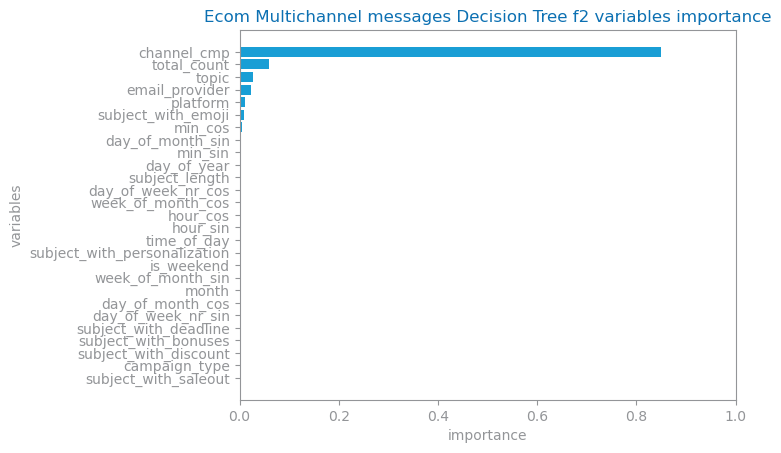

In [21]:
from numpy import argsort
from dslabs_functions import plot_horizontal_bar_chart

importances = best_model_prec.feature_importances_
indices: list[int] = argsort(importances)[::-1]
elems: list[str] = []
imp_values: list[float] = []
for f in range(len(vars)):
    elems += [vars[indices[f]]]
    imp_values += [importances[indices[f]]]
    print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

figure()
plot_horizontal_bar_chart(
    elems,
    imp_values,
    title=f"{file_tag} Decision Tree {f2_params['metric']} variables importance",
    xlabel="importance",
    ylabel="variables",
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_vars_ranking.png")
show()

## precision overfitting

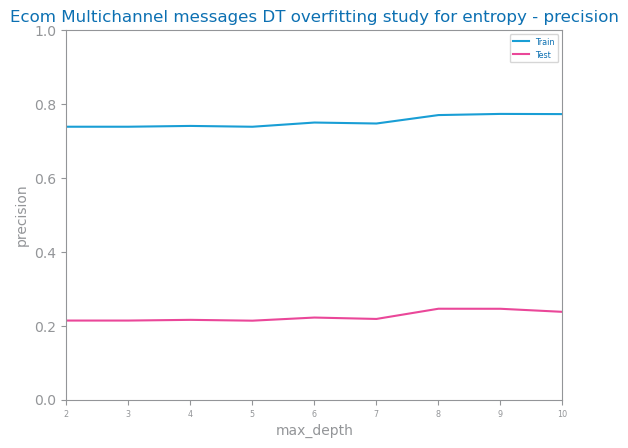

In [22]:
crit: Literal["entropy", "gini"] = prec_params["params"][0]
d_max = d_max_eval
depths: list[int] = [i for i in range(2, d_max + 1, 1)]
y_tst_values: list[float] = []
y_trn_values: list[float] = []
eval_metric = prec_params['metric']
for d in depths:
    clf = DecisionTreeClassifier(max_depth=d, criterion=crit, min_impurity_decrease=0)
    clf.fit(trnX, trnY)
    prd_tst_Y: array = clf.predict(tstX)
    prd_trn_Y: array = clf.predict(trnX)
    y_tst_values.append(CLASS_EVAL_METRICS[eval_metric](tstY, prd_tst_Y))
    y_trn_values.append(CLASS_EVAL_METRICS[eval_metric](trnY, prd_trn_Y))

figure()
plot_multiline_chart(
    depths,
    {"Train": y_trn_values, "Test": y_tst_values},
    title=f"{file_tag} DT overfitting study for {crit} - {prec_params['metric']}",
    xlabel="max_depth",
    ylabel=str(prec_params['metric']),
    percentage=True,
)
savefig(f"images/{file_tag}_dt_{prec_params['metric']}_overfitting.png")

# Analysis

- F2 DT best with entropy and d=4 
- Precision DT best with entropy and d=2

- there is high overfitting

- with a focus on f2 we have the following top variables by importance

1. traffic_source_source (0.734834806538122)
2. event_name (0.13345302260356195)
3. traffic_source_medium (0.10659741612362471)
4. engagement_time_msec (0.007780857791340006)
5. page_path_level_1 (0.0073798023833999)
6. path_length (0.006371182221495404)
7. session_engaged (0.0035829123384559284)

traffic alone is the major single variable that can affect if a user is returning or not also on precision